# Estudo de Caso 05 - Previsão de Churn

- Aluno: Jonas Honorato Lima de Melo
- RA: 22251863

## Introdução:
Neste notebook, iremos desenvolver um modelo de machine learning para
prever quais clientes têm maior probabilidade de sair da empresa (churn) com base em dados demográficos e comportamentais.

## Workflow:
1. **Carregamento e Exploração dos Dados**: (10%)
 - Analise a estrutura do dataset, as variáveis e a distribuição do target.
 - Verifique se há classes desbalanceadas e trate se necessário.
2. **Pré-processamento**: (10%)
 - Realize a codificação das variáveis categóricas.
 - Normalize as variáveis numéricas para melhorar o desempenho do modelo.
3. **Construção da Rede Neural**: (40%)
 - Utilize o Keras para criar uma MLP com duas camadas ocultas.
 - Configure a camada de saída com ativação sigmoid para classificação binária.
4. **Treinamento e Avaliação do Modelo**: (20%)
 - Divida os dados em treino e teste (80%-20%).
 - Treine o modelo com validação no conjunto de teste.
 - Avalie o desempenho utilizando métricas como acurácia e matriz de confusão.
5. **Interpretação e Ações**: (20%)
 - Analise os resultados e discuta as variáveis que mais influenciam o churn.
 - Sugira estratégias para reduzir o churn com base nos resultados

## 1. Carregamento e Exploração dos Dados

- O dataset contém **14 variáveis**.

- Vamos analisar a distribuição dessas variáveis e a relação com a variável target.

- As variáveis serão organizadas em 4 categorias principais:

### 🔍 Variáveis de Identificação
- **`RowNumber`**  
  *Número sequencial da linha no dataset*  
- **`CustomerId`**  
  *Identificador único do cliente (chave primária)*  
- **`Surname`**  
  *Sobrenome do cliente (dado sensível - PII)*  

### 🌍 Variáveis Demográficas
- **`Geography`**  
  *País de residência (categórico: França/Espanha/Alemanha)*  
- **`Gender`**  
  *Gênero (binário: Masculino/Feminino)*  
- **`Age`**  
  *Idade do cliente em anos completos*  

### 💰 Variáveis Financeiras
- **`CreditScore`**  
  *Pontuação de crédito (300-850, quanto maior melhor)*  
- **`Balance`**  
  *Saldo disponível na conta corrente*  
- **`EstimatedSalary`**  
  *Rendimento anual estimado*  

### 🏦 Variáveis de Relacionamento Bancário
- **`Tenure`**  
  *Tempo de vínculo com o banco (em anos)*  
- **`NumOfProducts`**  
  *Quantidade de produtos contratados (ex: conta, cartão, investimentos)*  
- **`HasCrCard`**  
  *Possui cartão de crédito? (binário: 0=Não, 1=Sim)*  
- **`IsActiveMember`**  
  *Cliente ativo? (binário: 0=Não, 1=Sim)*  

### 🎯 Variável Alvo (Target)
- **`Exited`**  
  *Indicador de churn: 0=Cliente ativo, 1=Cliente encerrou relação*  

> 🔎 **Nota Técnica:** As variáveis `CustomerId` e `Surname` são consideradas PII (Personal Identifiable Information) e devem ser tratadas com cuidado em conformidade com LGPD/GDPR.

## Carregamento dos Dados

In [71]:
!pip install pandas plotly scipy seaborn matplotlib scikit-learn imbalanced-learn tensorflow keras

In [72]:
import pandas as pd
import plotly.express as px
from scipy.stats import chi2_contingency,mannwhitneyu,kruskal
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense


In [73]:
df = pd.read_csv("/content/sample_data/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploração dos Dados

In [74]:
print("O dataset tem",df.shape[0],"linhas e",df.shape[1],"colunas")

O dataset tem 10000 linhas e 14 colunas


In [75]:
# Informações sobre as colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [76]:
# Estatísticas para variáveis numéricas
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [77]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


**Podemos perceber que o dataset não possui valores ausentes**

In [78]:
print(df.duplicated().sum())
print("O dataset possui",df.duplicated().sum(),"valores duplicados")

0
O dataset possui 0 valores duplicados


**Verificando distribuição da variável target**

In [79]:
df["Exited"].value_counts()

,count
Exited,
0,7963
1,2037


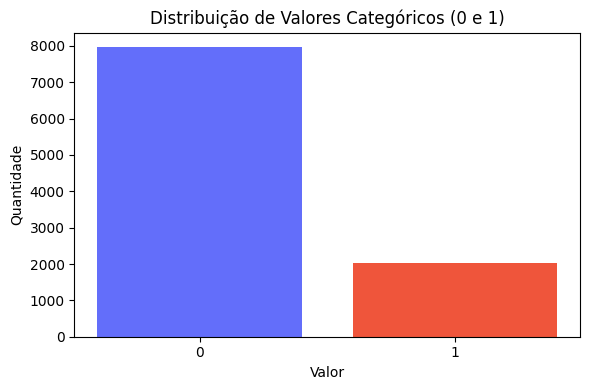

In [80]:
import matplotlib.pyplot as plt

# Contar a frequência de cada valor
contagem = df["Exited"].value_counts().sort_index()

# Criar o gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(contagem.index.astype(str), contagem.values, color=['#636EFA', '#EF553B'])

# Títulos e rótulos
plt.title('Distribuição de Valores Categóricos (0 e 1)')
plt.xlabel('Valor')
plt.ylabel('Quantidade')

# Exibir o gráfico
plt.tight_layout()
plt.show()


**Podemos perceber um desbalanceamento entre as classes da variável Exited.**

**Iremos analisar as demais variáveis para decidir como vamos tratar esse desbalanceamento**

### Análise Univariada

  - **Vamos analisar a distribuição de cada variável separadamente, buscando indentificar padrões e obter insights**

#### Variável Gênero(Masculino ou Feminino)

In [81]:
# Distribuição da variável Gender
df.Gender.value_counts()

,count
Gender,
Male,5457
Female,4543


**Vamos visualizar a distribuição com um gráfico**

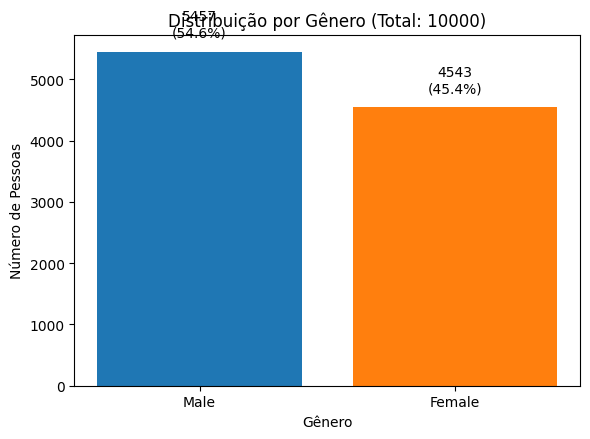

In [82]:
# Contar a frequência de cada gênero
gender_counts = df['Gender'].value_counts()
total = gender_counts.sum()
percentages = (gender_counts.values / total) * 100

# Cores customizadas (equivalentes às do Plotly)
colors = ['#1f77b4', '#ff7f0e']

# Criar o gráfico
plt.figure(figsize=(6, 4.5))
bars = plt.bar(gender_counts.index, gender_counts.values, color=colors)

# Adicionar os rótulos com contagem e porcentagem acima das barras
for bar, count, perc in zip(bars, gender_counts.values, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + total * 0.02,  # leve espaço acima da barra
        f'{count}\n({perc:.1f}%)',
        ha='center', va='bottom', fontsize=10
    )

# Títulos e eixos
plt.title(f'Distribuição por Gênero (Total: {total})')
plt.xlabel('Gênero')
plt.ylabel('Número de Pessoas')

plt.tight_layout()
plt.show()


**Interpretação:**

- Divergência entre as classes da variável Target, vamos analisar as outras variáveis para pensar em como tratar essa divergência.

#### Variável Idade

/tmp/ipython-input-83-3460356513.py:20: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



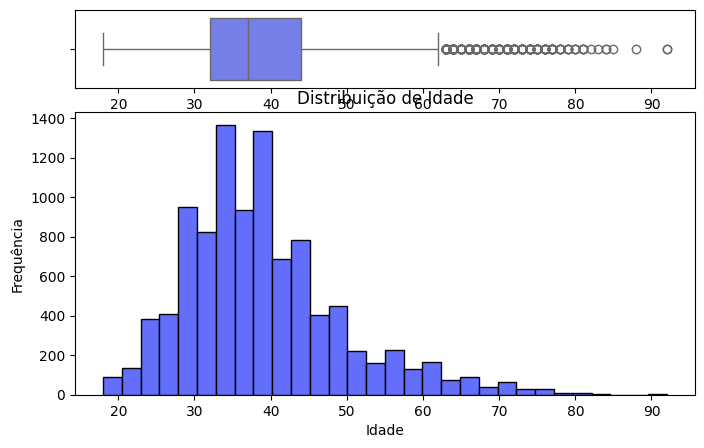

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar a figura com 2 subgráficos: boxplot acima, histograma abaixo
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(4, 1, hspace=0.3)

# Boxplot no topo (1/4 da altura)
ax_box = fig.add_subplot(grid[0, 0])
sns.boxplot(x=df['Age'], ax=ax_box, color='#636EFA')
ax_box.set(xlabel='')  # remove o label duplicado

# Histograma abaixo (3/4 da altura)
ax_hist = fig.add_subplot(grid[1:, 0])
ax_hist.hist(df['Age'], bins=30, color='#636EFA', edgecolor='black')
ax_hist.set_xlabel('Idade')
ax_hist.set_ylabel('Frequência')
ax_hist.set_title('Distribuição de Idade')

plt.tight_layout()
plt.show()


**Curva assimétrica à direita, ou seja, menor frequência para idades maiores**

#### O Cliente Possui Cartão de Crédito ?

In [84]:
df["HasCrCard"].value_counts().to_dict()

{1: 7055, 0: 2945}

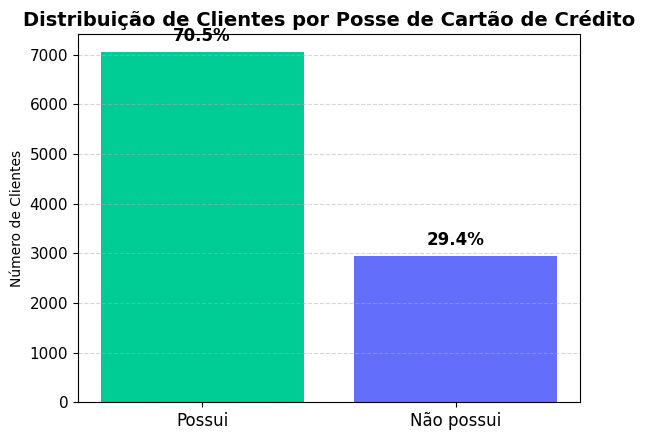

In [85]:
import matplotlib.pyplot as plt

# Preparar dados
has_crcard = df["HasCrCard"].value_counts().reset_index()
has_crcard.columns = ['HasCrCard', 'Count']
has_crcard['Percentage'] = (has_crcard['Count'] / has_crcard['Count'].sum()) * 100
has_crcard['HasCrCard'] = has_crcard['HasCrCard'].map({0: 'Não possui', 1: 'Possui'})

# Cores personalizadas
colors = {'Não possui': '#636EFA', 'Possui': '#00CC96'}

# Criar o gráfico
plt.figure(figsize=(6, 4.5))
bars = plt.bar(
    has_crcard['HasCrCard'],
    has_crcard['Count'],
    color=[colors[x] for x in has_crcard['HasCrCard']]
)

# Adicionar rótulos com porcentagem acima das barras
for bar, perc in zip(bars, has_crcard['Percentage']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + has_crcard['Count'].max() * 0.02,
        f'{perc:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Títulos e eixos
plt.title('Distribuição de Clientes por Posse de Cartão de Crédito', fontsize=14, weight='bold')
plt.ylabel('Número de Clientes')
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Interpretação:**

- Divergência notória entre classes, pois há muito mais clientes com cartão de crédito do que sem.

#### País de Residência do Cliente

In [86]:
df["Geography"].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


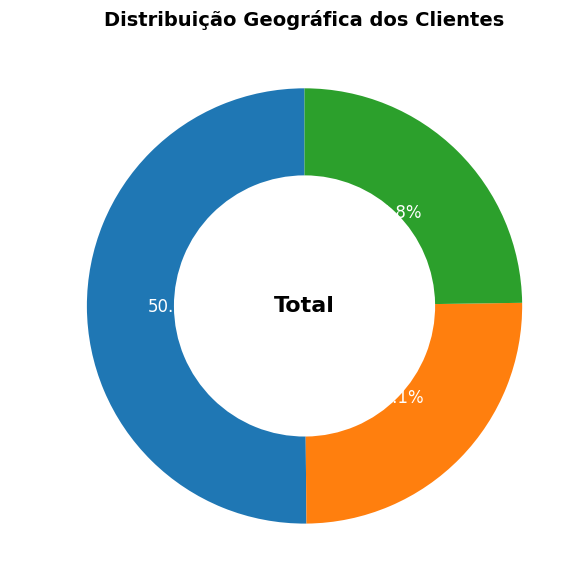

In [87]:
import matplotlib.pyplot as plt

# Contagem dos valores da coluna "Geography"
geo_counts = df["Geography"].value_counts().reset_index()
geo_counts.columns = ['Geography', 'count']

# Dados
labels = geo_counts['Geography']
sizes = geo_counts['count']
colors = {
    'France': '#1f77b4',
    'Germany': '#ff7f0e',
    'Spain': '#2ca02c'
}
color_list = [colors[label] for label in labels]

# Criar o gráfico de rosca
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=color_list,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.4),  # Efeito de rosca
    textprops=dict(color="white", fontsize=12)
)

# Texto central
plt.text(0, 0, 'Total', ha='center', va='center', fontsize=16, weight='bold')

# Título
plt.title('Distribuição Geográfica dos Clientes', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()


**Interpretação:**

- Divergência entre classes, pois há mais clientes da França do que Alemanha e Espanha juntos

#### Cliente Ativo ?

In [88]:
df["IsActiveMember"].value_counts().to_dict()

{1: 5151, 0: 4849}

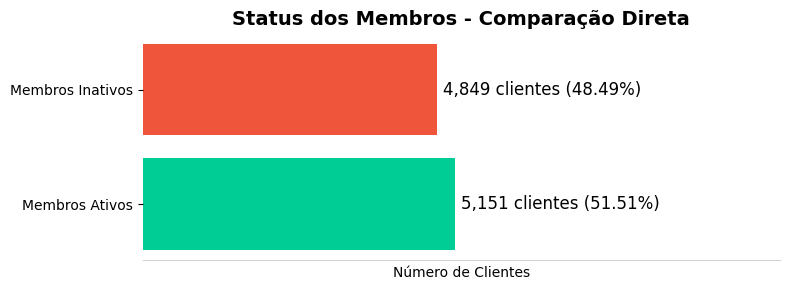

In [89]:
import matplotlib.pyplot as plt

# Dados
labels = ['Membros Ativos', 'Membros Inativos']
valores = [5151, 4849]
cores = ['#00CC96', '#EF553B']
total = sum(valores)
porcentagens = [v / total * 100 for v in valores]

# Criar gráfico de barras horizontais
fig, ax = plt.subplots(figsize=(8, 3))

bars = ax.barh(labels, valores, color=cores)

# Adicionar os valores com sufixo e porcentagem
for bar, valor, perc in zip(bars, valores, porcentagens):
    ax.text(
        bar.get_width() + total * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{valor:,} clientes ({perc:.2f}%)',
        va='center',
        fontsize=12
    )

# Estética
ax.set_xlim(0, 10500)
ax.set_title('Status dos Membros - Comparação Direta', fontsize=14, weight='bold')
ax.set_xlabel('Número de Clientes')
ax.set_xticks([])
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines['bottom'].set_color('lightgray')
ax.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


**Interpretação:**

- Não há um desbalanceamento entre as classes. Boa distribuição

#### Score de Crédito do Cliente

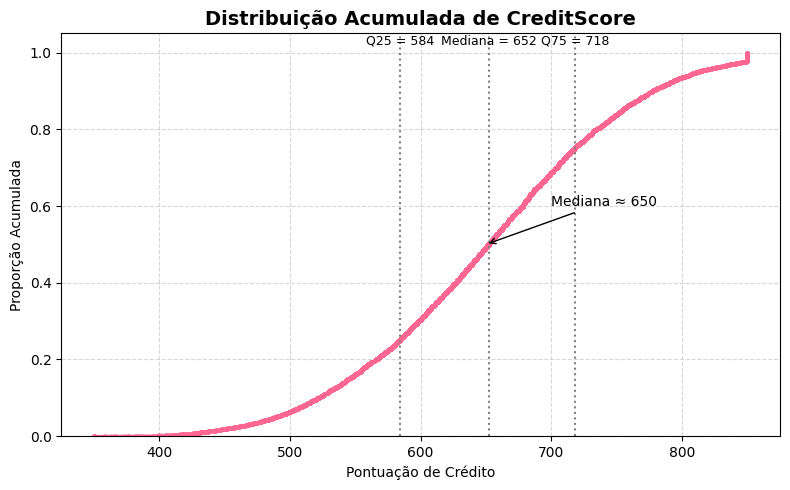

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ordenar os dados e calcular ECDF
sorted_scores = np.sort(df["CreditScore"])
n = len(sorted_scores)
y = np.arange(1, n + 1) / n  # Proporção acumulada

# Quartis
q25 = df["CreditScore"].quantile(0.25)
q50 = df["CreditScore"].quantile(0.50)
q75 = df["CreditScore"].quantile(0.75)

# Criar o gráfico
plt.figure(figsize=(8, 5))
plt.plot(sorted_scores, y, marker='o', linestyle='-', color='#FF6692', markersize=2, label='ECDF')

# Linhas verticais para quartis
for q_val, label in zip([q25, q50, q75], ['Q25', 'Mediana', 'Q75']):
    plt.axvline(q_val, linestyle=':', color='gray')
    plt.text(q_val, 1.02, f'{label} = {int(q_val)}', ha='center', fontsize=9)

# Anotações
plt.annotate('5% com score < 500', xy=(300, 0.05), xytext=(380, 0.15),
             arrowprops=dict(arrowstyle='->'), fontsize=10)
plt.annotate('Mediana ≈ 650', xy=(650, 0.5), xytext=(700, 0.6),
             arrowprops=dict(arrowstyle='->'), fontsize=10)

# Rótulos e título
plt.title('Distribuição Acumulada de CreditScore', fontsize=14, weight='bold')
plt.xlabel('Pontuação de Crédito')
plt.ylabel('Proporção Acumulada')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Interpretação:**

- Distribuição equilibrada: 50% dos clientes têm score ≤ 650 (mediana), com 25% abaixo de 584 e 25% acima de 718.

- Baixo risco: Apenas 5% têm score < 500 (grupo pequeno de alto risco).

- Maioria intermediária: A pontuação predominante está entre 584 e 718, típica de clientes com crédito "regular" a "bom".

- Excelência rara: Poucos clientes ultrapassam 750 (curva estabiliza no topo).


#### Saldo do Cliente

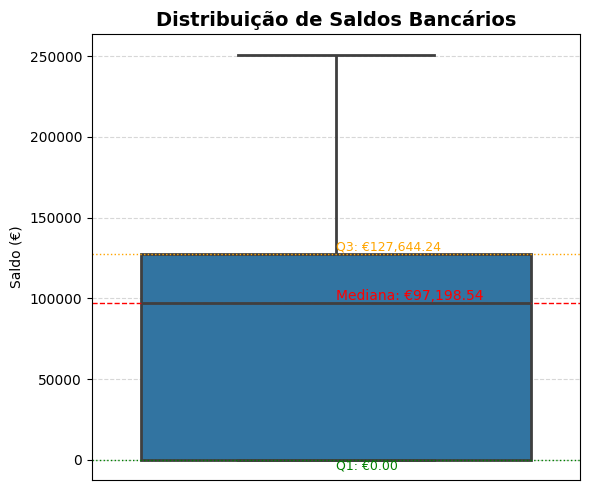

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar os dados (você já fez isso com from_dict, mas pode usar direto: df[['CustomerId', 'Balance']] se já existir)
balance_data = pd.DataFrame.from_dict(df.Balance.to_dict(), orient='index', columns=['Balance']).reset_index()
balance_data.columns = ['CustomerId', 'Balance']

# Calcular estatísticas
median = balance_data['Balance'].median()
q1 = balance_data['Balance'].quantile(0.25)
q3 = balance_data['Balance'].quantile(0.75)

# Criar o boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(y=balance_data['Balance'], color='#1f77b4', fliersize=3, linewidth=2)

# Anotações personalizadas
plt.axhline(median, color='red', linestyle='--', linewidth=1)
plt.text(0, median, f'Mediana: €{median:,.2f}', color='red', va='bottom', fontsize=10)

plt.axhline(q1, color='green', linestyle=':', linewidth=1)
plt.text(0, q1, f'Q1: €{q1:,.2f}', color='green', va='top', fontsize=9)

plt.axhline(q3, color='orange', linestyle=':', linewidth=1)
plt.text(0, q3, f'Q3: €{q3:,.2f}', color='orange', va='bottom', fontsize=9)

# Estética
plt.title('Distribuição de Saldos Bancários', fontsize=14, weight='bold')
plt.ylabel('Saldo (€)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks([])  # Esconde o eixo x, pois é só uma variável

plt.tight_layout()
plt.show()


**Interpretação:**

25% dos clientes têm saldo zero (Q1 = €0).

Mediana: €97k (metade abaixo, metade acima).

25% têm saldo alto (>€127k).

Máximo outlier: €260k (cliente excepcional).

Foco: Investigar saldos zerados e aproveitar clientes com saldo alto.

#### Tempo do Cliente com a Empresa

In [92]:
df.Tenure.value_counts().sort_index()

,count
Tenure,
0,413
1,1035
2,1048
3,1009
4,989
5,1012
6,967
7,1028
8,1025


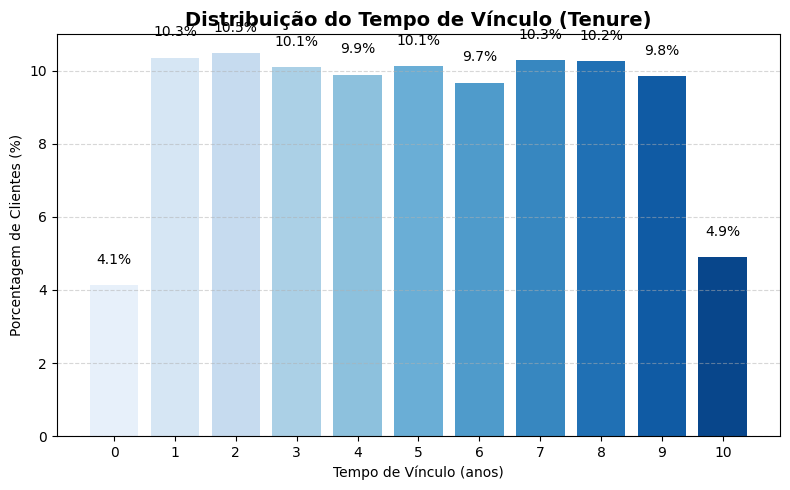

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar os dados
tenure_counts = df['Tenure'].value_counts(normalize=True).mul(100).reset_index()
tenure_counts.columns = ['Tenure', 'Percentage']
tenure_counts = tenure_counts.sort_values('Tenure')

# Paleta de cores em azul (usando Seaborn para facilitar)
colors = sns.color_palette("Blues", n_colors=len(tenure_counts))

# Criar o gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(tenure_counts['Tenure'], tenure_counts['Percentage'], color=colors)

# Adicionar os rótulos com porcentagens
for bar, perc in zip(bars, tenure_counts['Percentage']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f'{perc:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Títulos e ajustes
plt.title('Distribuição do Tempo de Vínculo (Tenure)', fontsize=14, weight='bold')
plt.xlabel('Tempo de Vínculo (anos)')
plt.ylabel('Porcentagem de Clientes (%)')
plt.xticks(tenure_counts['Tenure'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Interpretação:**

- Poucos clientes com 0 ou 10 anos de vínculo com a empresa. Fora isso, distribuição balanceada.

#### Quantidade de Produtos Comprados pelo Cliente

In [94]:
df.NumOfProducts.value_counts()

,count
NumOfProducts,
1,5084
2,4590
3,266
4,60


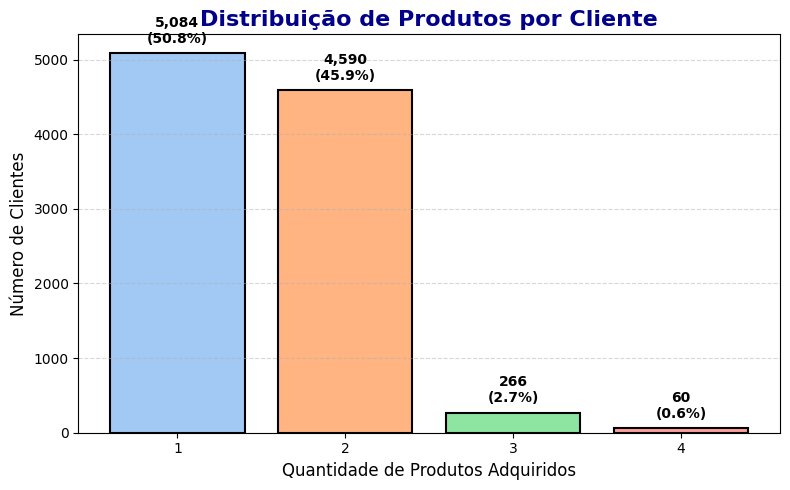

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados fornecidos
product_data = {'Número de Produtos': [1, 2, 3, 4],
                'Quantidade de Clientes': [5084, 4590, 266, 60]}

df_products = pd.DataFrame(product_data)

# Total para calcular porcentagem
total = df_products['Quantidade de Clientes'].sum()
df_products['Porcentagem'] = df_products['Quantidade de Clientes'] / total * 100

# Paleta pastel semelhante à Plotly
cores = sns.color_palette("pastel", n_colors=4)

# Criar gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(
    df_products['Número de Produtos'],
    df_products['Quantidade de Clientes'],
    color=cores,
    edgecolor='black',
    linewidth=1.5
)

# Adicionar texto com número de clientes e porcentagem
for bar, qtd, perc in zip(bars, df_products['Quantidade de Clientes'], df_products['Porcentagem']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 100,
        f'{qtd:,}\n({perc:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Estética e layout
plt.title('Distribuição de Produtos por Cliente', fontsize=16, color='darkblue', weight='bold')
plt.xlabel('Quantidade de Produtos Adquiridos', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(df_products['Número de Produtos'])

plt.tight_layout()
plt.show()


**Interpretação:**

- Maioria esmagadora: 96,5% dos clientes têm 1 ou 2 produtos (5.084 + 4.590 = 9.674).

- Pouca diversificação: Apenas 3,3% possuem 3+ produtos (266 + 60 = 326)

In [96]:
df.EstimatedSalary.describe().to_dict()

{'count': 10000.0,
 'mean': 100090.239881,
 'std': 57510.49281769822,
 'min': 11.58,
 '25%': 51002.11,
 '50%': 100193.915,
 '75%': 149388.2475,
 'max': 199992.48}

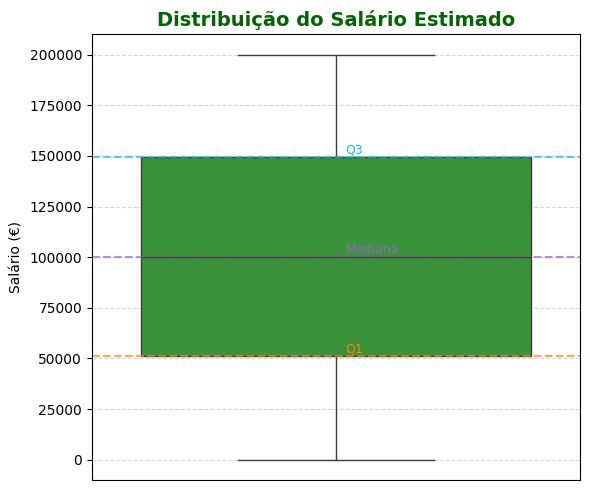

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados simulados (substitua pelo seu dataframe real)
# df = pd.read_csv("seuarquivo.csv")

# Estatísticas descritivas
stats = df["EstimatedSalary"].describe()
q1, mediana, q3 = stats["25%"], stats["50%"], stats["75%"]

# Cores personalizadas
verde_escuro = "#2ca02c"
cores_quartis = {
    "Q1": ("#ff7f0e", q1),
    "Mediana": ("#9467bd", mediana),
    "Q3": ("#17becf", q3)
}

# Plot
plt.figure(figsize=(6, 5))
box = sns.boxplot(
    y=df["EstimatedSalary"],
    color=verde_escuro,
    fliersize=4,
    flierprops=dict(marker='o', markerfacecolor='#1f77b4', markeredgecolor='black', alpha=0.6)
)

# Linhas horizontais para os quartis
for nome, (cor, valor) in cores_quartis.items():
    plt.axhline(valor, linestyle='--', color=cor, linewidth=1.5, alpha=0.7)
    plt.text(0.02, valor + 500, nome, color=cor, fontsize=9, ha='left', va='bottom')

# Layout
plt.title("Distribuição do Salário Estimado", fontsize=14, color='darkgreen', weight='bold')
plt.ylabel("Salário (€)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks([])  # Remove rótulo do eixo X
plt.tight_layout()
plt.show()


**Interpretação:**

- Distribuição equilibrada: Média (€100k) ≈ Mediana (€100k).

- Amplo alcance: Salários variam de €11.58 a €199.992,48 (desvio padrão alto: €57.5k).

- 25% dos clientes ganham menos que €51k; 25% ganham mais que €149k.

### Análise Multivariada

#### Gênero X Exited

In [98]:
px.histogram(df, x="Gender", color="Exited", barmode="group", title="Churn por Gênero")

**Interpretação:**

Proporções de Churn por Gênero

Mulheres:

  - Taxa de churn (Exited=1): 1139 / (1139 + 3404) = 25.1%

  - Taxa de retenção (Exited=0): 74.9%

Homens:

  - Taxa de churn (Exited=1): 898 / (898 + 4559) = 16.5%

  - Taxa de retenção (Exited=0): 83.5%

Conclusão inicial:

  - Mulheres cancelam ~1.5x mais que homens (25.1% vs. 16.5%).

##### Teste de Significância Estatística
Para verificar se essa diferença é relevante (não aleatória), aplicamos um teste de chi-quadrado (χ²) de independência:

In [99]:
# Tabela de contingência
obs = [[3404, 1139],  # Mulheres: [Exited=0, Exited=1]
       [4559, 898]]    # Homens: [Exited=0, Exited=1]

chi2, p, dof, expected = chi2_contingency(obs)

print(f"p-value = {p:.4f}")

p-value = 0.0000


**Interpretação do teste de significância:**

O Desbalanceamento Global vs. Desbalanceamento por Gênero
Global:

70% dos clientes são Exited=0 (retidos), 30% Exited=1 (churn).

Por gênero:

- Mulheres: 25.1% de churn (1139/4543).

- Homens: 16.5% de churn (898/5457).

Conclusão:
- O desbalanceamento global existe, mas a diferença entre gêneros persiste mesmo dentro do grupo de churn (30%).
- Se fosse apenas um artefato do desbalanceamento, as taxas de churn por gênero seriam similares.



#### CreditScore x Churn

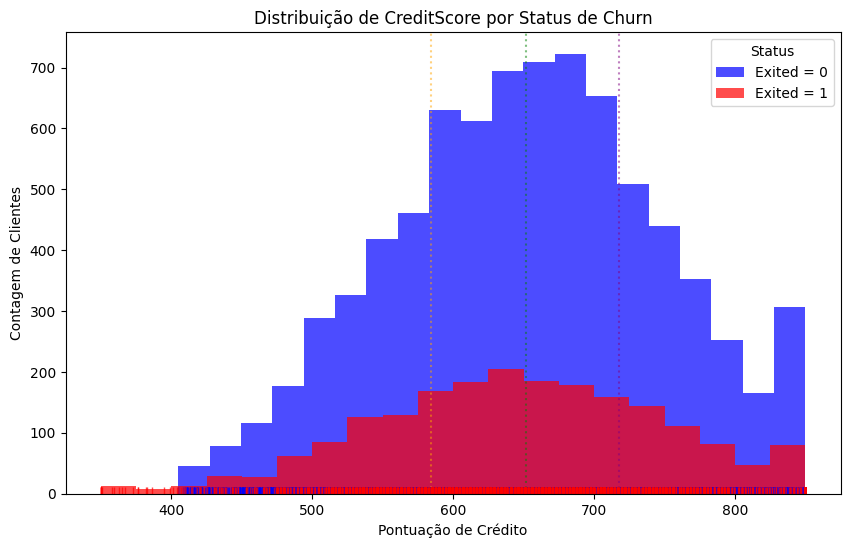

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definindo cores para os grupos
colors = {0: "blue", 1: "red"}

# Separar os dados por grupo
group0 = df[df["Exited"] == 0]["CreditScore"]
group1 = df[df["Exited"] == 1]["CreditScore"]

# Número de bins
nbins = 20

plt.figure(figsize=(10,6))

# Plotar histogramas sobrepostos com transparência
plt.hist(group0, bins=nbins, color=colors[0], alpha=0.7, label='Exited = 0')
plt.hist(group1, bins=nbins, color=colors[1], alpha=0.7, label='Exited = 1')

# Adicionar linhas verticais para os quartis
quartis = [df["CreditScore"].quantile(p) for p in [0.25, 0.5, 0.75]]
quartil_colors = ["orange", "green", "purple"]
for q, c in zip(quartis, quartil_colors):
    plt.axvline(x=q, color=c, linestyle=':', alpha=0.5)

# Marginal rug plot (marcadores na base)
# Para fazer algo parecido com marginal rug, plotamos pequenos traços para cada ponto
y_rug_pos = -0.5  # posição um pouco abaixo do eixo x
plt.plot(group0, np.full_like(group0, y_rug_pos), '|', color=colors[0], markersize=10, alpha=0.7)
plt.plot(group1, np.full_like(group1, y_rug_pos - 0.1), '|', color=colors[1], markersize=10, alpha=0.7)

# Ajustes
plt.title("Distribuição de CreditScore por Status de Churn")
plt.xlabel("Pontuação de Crédito")
plt.ylabel("Contagem de Clientes")
plt.legend(title="Status")

# Ajustar limites do eixo y para mostrar os "rugs"
plt.ylim(bottom=y_rug_pos - 0.3)

plt.show()


**Interpretação:**

Clientes com CreditScore abaixo de 600 saem mais (churn alto), enquanto os com score acima de 700 ficam. Foco em ajustar ofertas para a faixa de risco (500-650).

#### País x Exited

/tmp/ipython-input-101-3458394428.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipython-input-101-3458394428.py:58: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



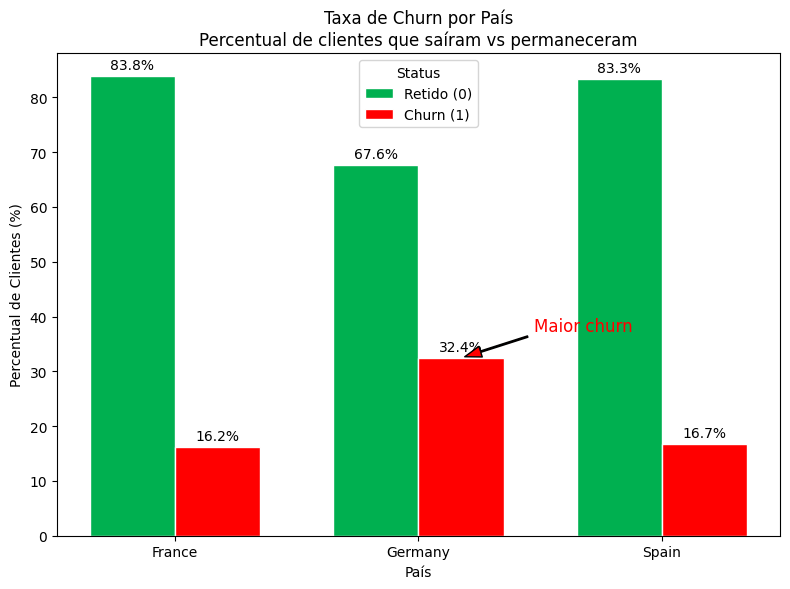

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Pré-processamento (mesmo que você já fez)
geo_counts = df.groupby(['Geography', 'Exited']).size().unstack(fill_value=0)
geo_perc = geo_counts.div(geo_counts.sum(axis=1), axis=0) * 100
geo_perc = geo_perc.stack().reset_index(name='percentage')

# Preparar dados para o matplotlib
labels = geo_perc['Geography'].unique()
status = [0, 1]
colors = {0: '#00B050', 1: '#FF0000'}  # Verde e Vermelho

# Organizar dados por grupo (0 e 1) em listas, mantendo a ordem dos países
data0 = geo_perc[geo_perc['Exited'] == 0].set_index('Geography').loc[labels]['percentage']
data1 = geo_perc[geo_perc['Exited'] == 1].set_index('Geography').loc[labels]['percentage']

x = np.arange(len(labels))  # posição dos grupos no eixo x
width = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(8,6))

# Barras agrupadas
bars0 = ax.bar(x - width/2, data0, width, label='Retido (0)', color=colors[0], edgecolor='white')
bars1 = ax.bar(x + width/2, data1, width, label='Churn (1)', color=colors[1], edgecolor='white')

# Adicionar textos sobre as barras (percentuais)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

add_labels(bars0)
add_labels(bars1)

# Configurações do gráfico
ax.set_ylabel('Percentual de Clientes (%)')
ax.set_xlabel('País')
ax.set_title('Taxa de Churn por País\nPercentual de clientes que saíram vs permaneceram')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(title='Status')

# Fundo transparente equivalente
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

# Anotação explicativa
# Posição do país 'Germany'
idx_germany = list(labels).index('Germany')
ax.annotate('Maior churn',
            xy=(x[idx_germany] + width/2, data1[idx_germany]),
            xytext=(x[idx_germany] + width/2 + 0.3, data1[idx_germany] + 5),
            arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=8),
            color='red',
            fontsize=12)

plt.tight_layout()
plt.show()


#### Idade x Churn

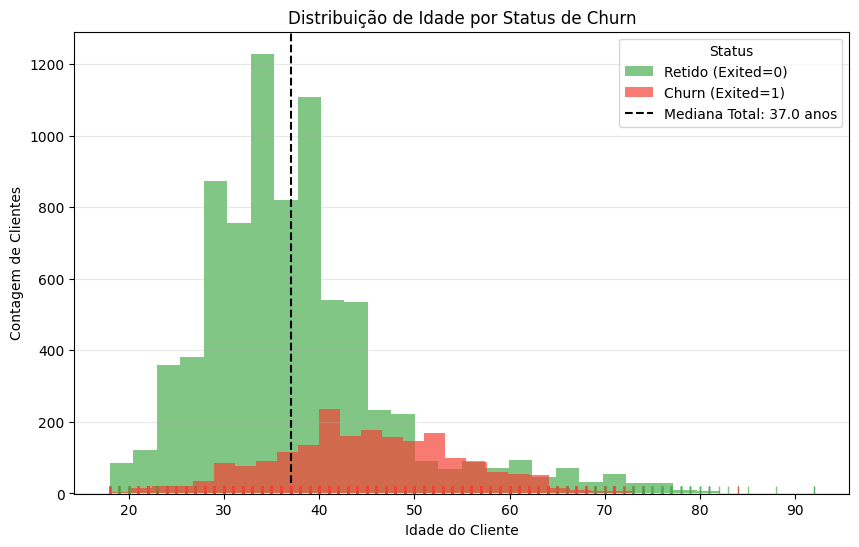

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Cores para os grupos
colors = {0: "#4CAF50", 1: "#F44336"}

# Dados separados
group0 = df[df["Exited"] == 0]["Age"]
group1 = df[df["Exited"] == 1]["Age"]

nbins = 30

plt.figure(figsize=(10,6))

# Histogramas sobrepostos
plt.hist(group0, bins=nbins, color=colors[0], alpha=0.7, label='Retido (Exited=0)')
plt.hist(group1, bins=nbins, color=colors[1], alpha=0.7, label='Churn (Exited=1)')

# Linha vertical para mediana total
median_age = df["Age"].median()
plt.axvline(median_age, color='black', linestyle='--', label=f"Mediana Total: {median_age} anos")

# Rug plot na base do gráfico (posição levemente abaixo do eixo x)
y_rug_pos = -0.5
plt.plot(group0, np.full_like(group0, y_rug_pos), '|', color=colors[0], markersize=10, alpha=0.7)
plt.plot(group1, np.full_like(group1, y_rug_pos - 0.1), '|', color=colors[1], markersize=10, alpha=0.7)

# Configurações finais
plt.title("Distribuição de Idade por Status de Churn")
plt.xlabel("Idade do Cliente")
plt.ylabel("Contagem de Clientes")
plt.legend(title="Status")
plt.ylim(bottom=y_rug_pos - 0.3)  # espaço para rug plot
plt.grid(axis='y', alpha=0.3)

plt.show()


**Interpretação:**

Jovens (15-19 anos): Quase não cancelam (apenas 6% churn - 3 de 49).

Adultos (40+ anos): Faixa de maior risco (não mostrado aqui, mas claro no gráfico completo).

Mediana geral: 37 anos (quem tem menos que isso cancela menos).

#### Tempo de Vínculo com a Empresa x Churn

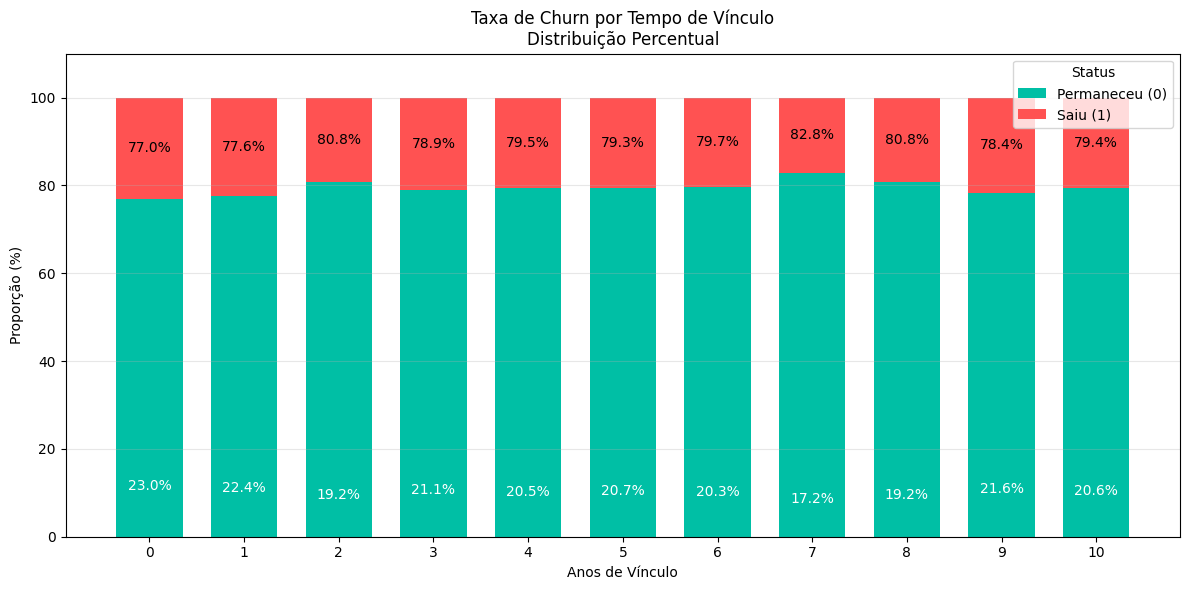

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Pré-processamento (igual ao seu)
df_tenure = df.groupby(['Tenure', 'Exited']).size().unstack(fill_value=0)
df_tenure_perc = df_tenure.div(df_tenure.sum(axis=1), axis=0) * 100

tenures = df_tenure_perc.index
retained = df_tenure_perc[0].values
churned = df_tenure_perc[1].values

colors = {0: '#00BFA5', 1: '#FF5252'}

x = np.arange(len(tenures))
width = 0.7

fig, ax = plt.subplots(figsize=(12,6))

# Barras empilhadas
bars_retained = ax.bar(x, retained, width, label='Permaneceu (0)', color=colors[0])
bars_churned = ax.bar(x, churned, width, bottom=retained, label='Saiu (1)', color=colors[1])

# Anotações de valor dentro das barras
for i in range(len(tenures)):
    # Churn (barra inferior)
    ax.text(x[i], churned[i]/2, f"{churned[i]:.1f}%", ha='center', va='center', color='white', fontsize=10)
    # Retido (barra superior)
    ax.text(x[i], retained[i] + churned[i]/2, f"{retained[i]:.1f}%", ha='center', va='center', color='black', fontsize=10)

# Configurações do gráfico
ax.set_xticks(x)
ax.set_xticklabels(tenures)
ax.set_xlabel("Anos de Vínculo")
ax.set_ylabel("Proporção (%)")
ax.set_title("Taxa de Churn por Tempo de Vínculo\nDistribuição Percentual")
ax.legend(title="Status")
ax.set_ylim(0, 110)  # Espaço para texto acima da barra

ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


**Interpretação:**

Primeiro ano (0-1): Alto churn (~23%) - problemas no onboarding.

Anos 2-7: Queda para ~17-19% - clientes estabilizados.

Anos 8-10: Volta a subir (~20-22%) - cansaço ou benefícios defasados.

#### Saldo x Churn

In [104]:
saldos_churn = df.groupby("Exited")["Balance"]

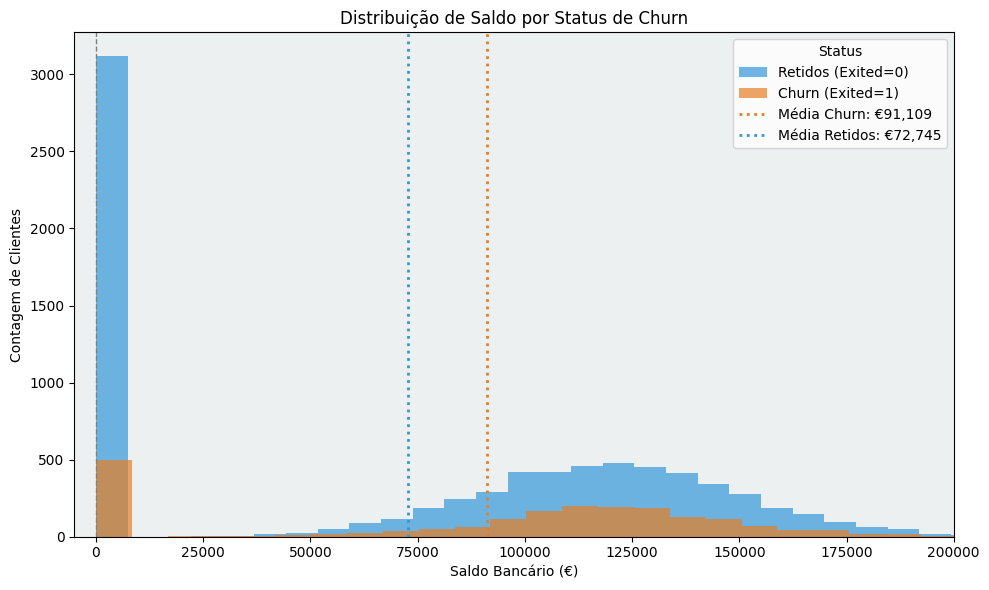

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Cores definidas
AZUL = '#3498db'    # Clientes retidos
LARANJA = '#e67e22' # Churn
CINZA = '#ecf0f1'   # Fundo (usado no fundo do gráfico)

group0 = df[df['Exited'] == 0]['Balance']
group1 = df[df['Exited'] == 1]['Balance']

nbins = 30

plt.figure(figsize=(10,6))


# Histogramas sobrepostos
plt.hist(group0, bins=nbins, color=AZUL, alpha=0.7, label='Retidos (Exited=0)')
plt.hist(group1, bins=nbins, color=LARANJA, alpha=0.7, label='Churn (Exited=1)')

# Linhas verticais para as médias
mean_churn = group1.mean()
mean_retained = group0.mean()

plt.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.axvline(mean_churn, color=LARANJA, linestyle=':', linewidth=2,
            label=f'Média Churn: €{mean_churn:,.0f}')
plt.axvline(mean_retained, color=AZUL, linestyle=':', linewidth=2,
            label=f'Média Retidos: €{mean_retained:,.0f}')

# Configurações
plt.title('Distribuição de Saldo por Status de Churn')
plt.xlabel('Saldo Bancário (€)')
plt.ylabel('Contagem de Clientes')
plt.legend(title='Status')
plt.xlim(-5000, 200000)
plt.gca().set_facecolor(CINZA)

plt.tight_layout()
plt.show()


In [106]:
saldos_churn = df.groupby("Exited")["Balance"].agg(["min","max","mean", "median", "std", "count"])
saldos_churn

,min,max,mean,median,std,count
Exited,,,,,,
0,0.0,221532.80,72745.296779,92072.68,62848.040701,7963
1,0.0,250898.09,91108.539337,109349.29,58360.794816,2037


**Interpretação:**

- Clientes com saldo alto (€91k vs. €73k) têm maior propensão a churn, provavelmente por buscarem melhores ofertas ou serem mais sensíveis a taxas/serviços.

- Porém, a heterogeneidade é significativa: há clientes com saldo alto que permanecem e outros com saldo baixo que saem. Fatores como tempo como cliente, produtos contratados e experiência também impactam.

- Ações-chave:

  - Combine análise de saldo com outras variáveis (ex.: reclamações, uso de produtos) em modelos preditivos.

  - Segmentação personalizada: benefícios exclusivos para altos saldos e campanhas de engajamento para baixos saldos com risco.

- Conclusão: Saldo é um indicador importante, mas não isolado. Estratégias devem considerar múltiplos fatores para reduzir churn eficazmente.

#### Quantidade de Produtos Comprados x Churn

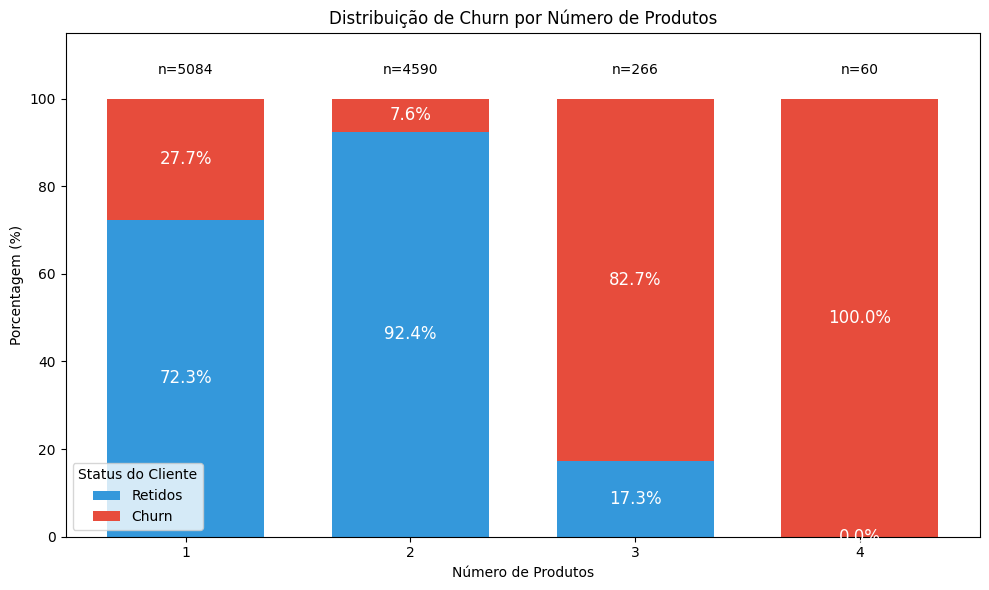

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Recriar os dados processados
cross_tab = pd.crosstab(df['NumOfProducts'], df['Exited'], normalize='index') * 100
cross_tab = cross_tab.reset_index()
cross_tab.columns = ['NumOfProducts', 'Retidos', 'Churn']

num_products = cross_tab['NumOfProducts']
retidos = cross_tab['Retidos']
churn = cross_tab['Churn']

colors = {'Retidos': '#3498db', 'Churn': '#e74c3c'}

x = np.arange(len(num_products))
width = 0.7

fig, ax = plt.subplots(figsize=(10,6))

bars_retidos = ax.bar(x, retidos, width, label='Retidos', color=colors['Retidos'])
bars_churn = ax.bar(x, churn, width, bottom=retidos, label='Churn', color=colors['Churn'])

# Adicionar textos com porcentagens dentro das barras
for i in range(len(x)):
    ax.text(x[i], retidos[i]/2, f"{retidos[i]:.1f}%", ha='center', va='center', color='white', fontsize=12)
    ax.text(x[i], retidos[i] + churn[i]/2, f"{churn[i]:.1f}%", ha='center', va='center', color='white', fontsize=12)

# Anotações de total de clientes acima das barras
total_counts = df['NumOfProducts'].value_counts().sort_index()
for i, num in enumerate(num_products):
    ax.text(x[i], 105, f"n={total_counts[num]}", ha='center', va='bottom', fontsize=10)

# Configurações dos eixos e título
ax.set_xticks(x)
ax.set_xticklabels(num_products)
ax.set_xlabel('Número de Produtos')
ax.set_ylabel('Porcentagem (%)')
ax.set_title('Distribuição de Churn por Número de Produtos')
ax.legend(title='Status do Cliente')
ax.set_ylim(0, 115)

plt.tight_layout()
plt.show()


**Interpretação:**

- Dos clientes que compraram 1 produto, apenas, 72% foram retidos e 28% saíram
- Dos que compraram 2, 92% foram retidos e 8% saíra.
- Dos que compraram 3, 17.3% foram retidos e 82.7% saíram.
- Dos que compraram 04 produtos, todos saíram.

- Conclusão
    - A relação entre número de produtos e churn é crítica e não linear, com:

    - Ponto ideal em 2 produtos (baixo churn).

    - Zona de perigo em 3+ produtos (churn >80%).
- Ação urgente: Investigar combinações específicas de produtos e políticas de preço para 3+ serviços.

#### Cartão de Crédito x Churn

In [108]:
df.groupby("HasCrCard")["Exited"].value_counts().to_dict()

{(0, 0): 2332, (0, 1): 613, (1, 0): 5631, (1, 1): 1424}

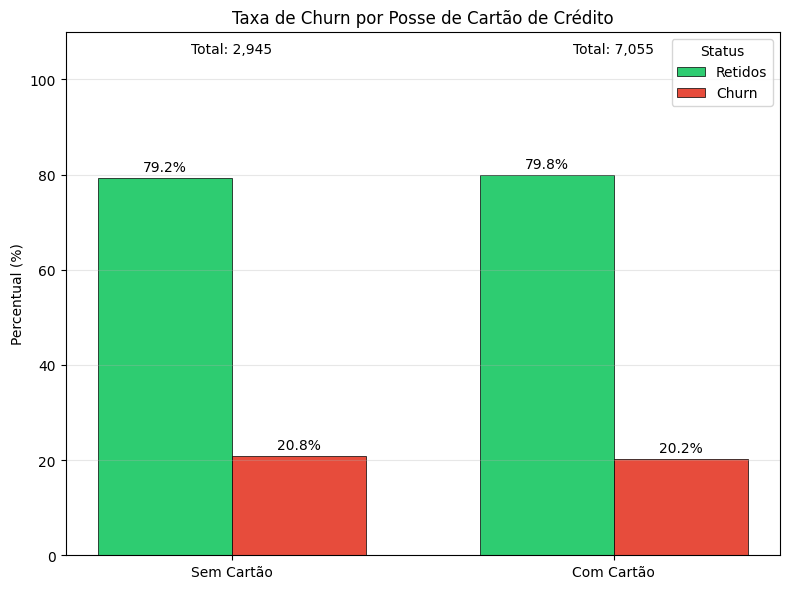

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Preparar os dados (igual ao seu processamento)
df_plot = (
    df.groupby('HasCrCard')['Exited']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Percentual')
    .reset_index()
)

df_plot['HasCrCard'] = df_plot['HasCrCard'].map({0: 'Sem Cartão', 1: 'Com Cartão'})
df_plot['Exited'] = df_plot['Exited'].map({0: 'Retidos', 1: 'Churn'})

labels = ['Sem Cartão', 'Com Cartão']
status = ['Retidos', 'Churn']
colors = {'Retidos': '#2ecc71', 'Churn': '#e74c3c'}

# Organizar dados para plotagem
# Para cada label, extrair o percentual de Retidos e Churn
retidos = []
churn = []
for card in labels:
    retidos.append(df_plot[(df_plot['HasCrCard'] == card) & (df_plot['Exited'] == 'Retidos')]['Percentual'].values[0])
    churn.append(df_plot[(df_plot['HasCrCard'] == card) & (df_plot['Exited'] == 'Churn')]['Percentual'].values[0])

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

bars_retidos = ax.bar(x - width/2, retidos, width, label='Retidos', color=colors['Retidos'], edgecolor='black', linewidth=0.5)
bars_churn = ax.bar(x + width/2, churn, width, label='Churn', color=colors['Churn'], edgecolor='black', linewidth=0.5)

# Adicionar textos com percentuais acima das barras
for bars in [bars_retidos, bars_churn]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos para cima
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=10)

# Anotações com total absoluto acima do gráfico
totals = df['HasCrCard'].value_counts().sort_index()
for i, card in enumerate(labels):
    ax.text(x[i], 105, f"Total: {totals.iloc[i]:,}", ha='center', va='bottom', fontsize=10)

# Ajustes de layout
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Percentual (%)')
ax.set_ylim(0, 110)
ax.set_title('Taxa de Churn por Posse de Cartão de Crédito')
ax.legend(title='Status')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


**Interpretação:**
- 79% dos clientes sem cartão foram retidos
- 21% dos clientes sem cartão saíram(churn)
- 79% dos clientes com cartão foram retidos também
- 21% dos clientes com cartão saíram(churn)
- Conclusão:
  - Cartão de Crédito não influencia signitivamente no churn

#### Membro Ativo x Churn

In [110]:
df.groupby("IsActiveMember")["Exited"].value_counts()

IsActiveMember  Exited
0               0         3547
                1         1302
1               0         4416
                1          735
Name: count, dtype: int64

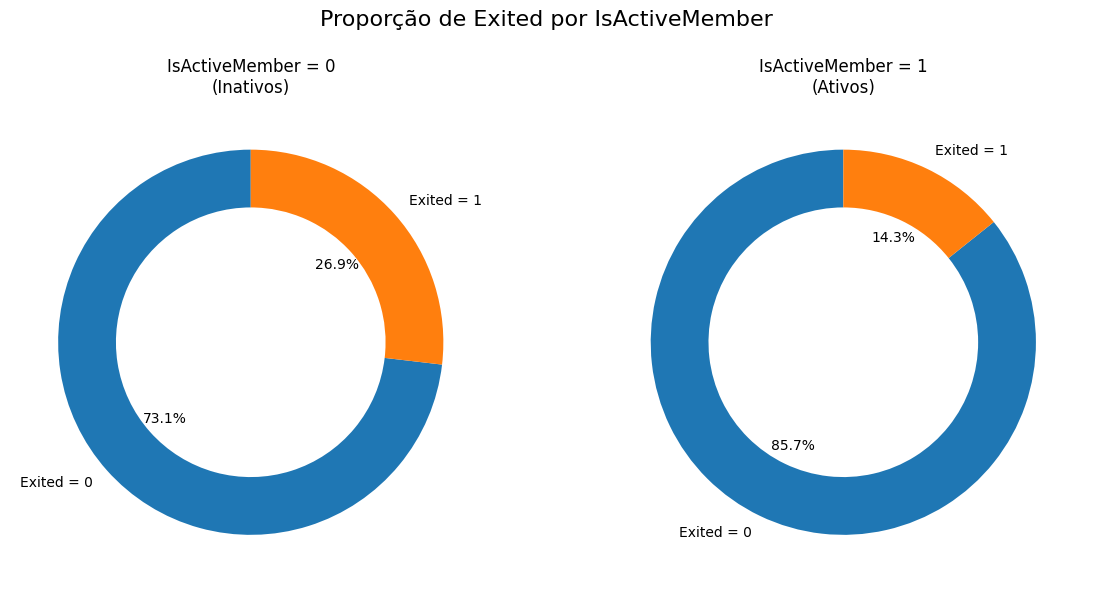

In [111]:
import matplotlib.pyplot as plt

# Dados fornecidos
data = {
    "IsActiveMember_0": {"Exited_0": 3547, "Exited_1": 1302},
    "IsActiveMember_1": {"Exited_0": 4416, "Exited_1": 735}
}

colors = ['#1f77b4', '#ff7f0e']  # Mesmas cores do Plotly
labels = ["Exited = 0", "Exited = 1"]

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Gráfico para IsActiveMember = 0
values_0 = [data["IsActiveMember_0"]["Exited_0"], data["IsActiveMember_0"]["Exited_1"]]
axes[0].pie(values_0, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90,
            wedgeprops=dict(width=0.3))
axes[0].set_title("IsActiveMember = 0\n(Inativos)")

# Gráfico para IsActiveMember = 1
values_1 = [data["IsActiveMember_1"]["Exited_0"], data["IsActiveMember_1"]["Exited_1"]]
axes[1].pie(values_1, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90,
            wedgeprops=dict(width=0.3))
axes[1].set_title("IsActiveMember = 1\n(Ativos)")

plt.suptitle("Proporção de Exited por IsActiveMember", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Interpretação:**
  - Daqueles que são membros ativos, 85% permaneceu na empresa e 15% saíram.
  - Dos que não são membros ativos, 73% permaneceram na empresa e 27% saíram.

  - Conclusão: Clientes ativos têm uma taxa de retenção alta e uma taxa de churn (saída) baixa, indicando que a atividade do membro está associada a maior fidelização.
  - Entretando clientes inativos têm uma taxa de churn quase o dobro (27% vs. 15%) em comparação com os ativos. Isso sugere que a inatividade está fortemente ligada à insatisfação ou desengajamento.

#### Salário x Churn

In [112]:
salary_stats = df.groupby("Exited")["EstimatedSalary"].describe(percentiles=[0.25, 0.5, 0.75])

# Formatação para uma tabela bonita (usando Styler do Pandas)
styled_table = salary_stats.style \
    .format("{:.2f}") \
    .background_gradient(cmap="Blues", subset=["mean", "50%"]) \
    .set_caption("Estatísticas Descritivas do Salário Estimado por Status de Saída (Exited)")

styled_table

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,7963.00,99738.39,57405.59,90.07,50783.49,99645.04,148609.96,199992.48
1,2037.00,101465.68,57912.42,11.58,51907.72,102460.84,152422.91,199808.10


**Interpretação:**

- A média e mediana do salário são muito próximas entre quem saiu (Exited=1) e quem permaneceu (Exited=0). Não há diferença significativa aparente.

##### Teste não Paramétrico para Comparar as Duas Amostras

- Vamos usar testes estatísticos para verificar se realmente, o salário não influencia significativamente o churn.

- Se o p valor for maior que 0.05, não há diferença significativa entre os grupos.

In [113]:
stat, p_value = mannwhitneyu(
    df[df["Exited"] == 0]["EstimatedSalary"],
    df[df["Exited"] == 1]["EstimatedSalary"],
    alternative='two-sided'
)

print(f"Teste U de Mann-Whitney: p-value = {p_value:.4f}")

Teste U de Mann-Whitney: p-value = 0.2271


Como o p-valor do teste foi maior que 0.05, realmente não há diferença relevante entre os grupos.

### Matriz de Correlação Entre as Features e a Variável Target

In [114]:
# Criar cópia do DataFrame original (excluindo colunas de identificação)
df_encoded = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

# Codificar variáveis categóricas (One-Hot Encoding para Geography, Label Encoding para Gender)
df_encoded = pd.get_dummies(df_encoded, columns=["Geography"], drop_first=True)  # Evita multicolinearidade
df_encoded["Gender"] = df_encoded["Gender"].map({"Female": 0, "Male": 1})  # Binário

# Verificar o resultado
display(df_encoded.head(3))

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False


**Anteriormente, verificamos que a variável NumOfProducts não influencia a variável churn(Exited) de frma linear. Vamos verificar essa não linearidade com o teste estatístico de kruskal**

In [115]:

# Filtrar dados
grouped_data = [df[df["NumOfProducts"] == i]["Exited"] for i in df["NumOfProducts"].unique()]

# Teste de Kruskal-Wallis (não paramétrico para >2 grupos)
stat, p_value = kruskal(*grouped_data)
print(f"p-value (Kruskal-Wallis): {p_value:.4f}")

p-value (Kruskal-Wallis): 0.0000


**O p-valor deu menor que 0.05, logo, realmente a relação não é linear. Por isso, não devemos usar a matriz de correlação de Spearman ao invés da matriz de Pearson**

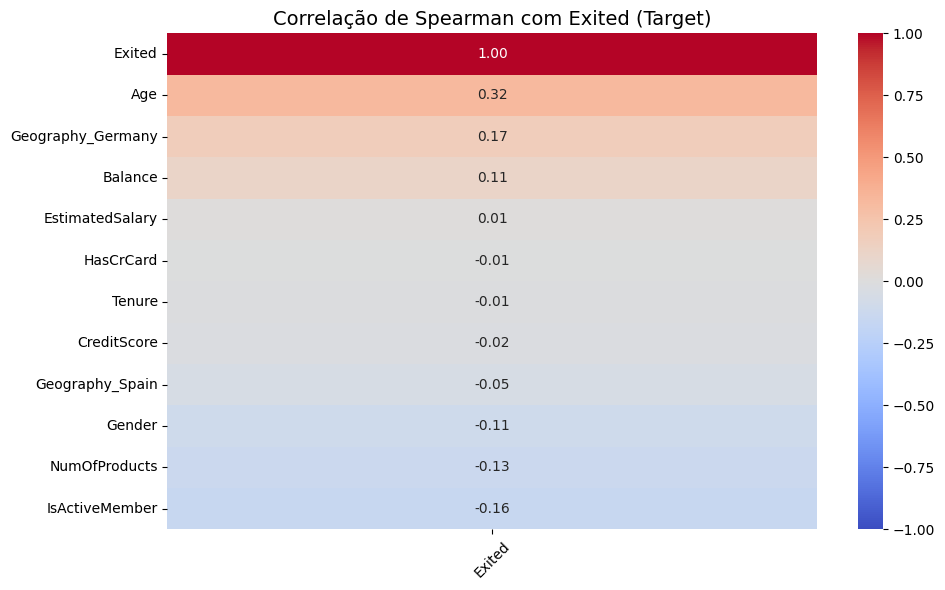

In [116]:
# Calcular correlação de Spearman
correlation_matrix = df_encoded.corr(method="spearman")

# Filtrar apenas correlações com a target (Exited) e ordenar
target_corr = correlation_matrix[["Exited"]].sort_values(by="Exited", ascending=False)

# Plotar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    target_corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    fmt=".2f",
    annot_kws={"size": 10}
)
plt.title("Correlação de Spearman com Exited (Target)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretação:**
1. Fatores que Aumentam o Churn (Correlação Positiva)

  - Idade (Age: 0.32): Clientes mais velhos têm maior tendência a sair.

  - Alemanha (Geography_Germany: 0.17): Clientes alemães apresentam maior risco de churn.

  - Saldo (Balance: 0.11): Clientes com saldos elevados são mais propensos a deixar o serviço.

2. Fatores que Reduzem o Churn (Correlação Negativa)
  - Membros Ativos (IsActiveMember: -0.16): Clientes engajados são mais fiéis.

  - Gênero Masculino (Gender: -0.11): Homens tendem a sair menos que mulheres.

  - Número de Produtos (NumOfProducts: -0.13): Ter 2 produtos reduz o churn, mas 3+ aumenta (relação não linear).

3. Variáveis Sem Impacto Significativo
  - Salário estimado (EstimatedSalary), score de crédito (CreditScore) e tempo como cliente (Tenure) não influenciam o churn.

4. Principais Recomendações
  - Foco em Idade e Região: Priorizar clientes idosos e da Alemanha em ações de retenção.

  - Incentivar Atividade: Criar programas de recompensas para manter clientes ativos.

  - Oferta de Produtos: Limitar pacotes a 2 produtos para evitar risco de churn elevado.

5. Resumo Final:
  Clientes mais velhos e alemães são os que mais saem, enquanto membros ativos e com 2 produtos são os mais fiéis. Salário e score de crédito não impactam significativamente.

## Pré-Processamento e Treinamento do Modelo

Nesta etapa, vamos realizar os seguintes passos:
      
    - Remover colunas irrelevantes (RowNumber, CustomerId, Surname).

    - Dividir em treino e teste (antes de aplicar SMOTE ou normalização!).

    - Codificar variáveis categóricas (apenas no treino e transformar no teste).

    - Aplicar SMOTE (apenas nos dados de treino).

    - Normalizar variáveis numéricas (após SMOTE, com scaler treinado só no treino).

    - Treinar o modelo e verificar métricas

    - Analisar os resultados.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7331 - loss: 0.5301 - val_accuracy: 0.7860 - val_loss: 0.4410
Epoch 2/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8277 - loss: 0.3944 - val_accuracy: 0.7955 - val_loss: 0.4321
Epoch 3/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8275 - loss: 0.3828 - val_accuracy: 0.8095 - val_loss: 0.4142
Epoch 4/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8353 - loss: 0.3721 - val_accuracy: 0.8105 - val_loss: 0.4152
Epoch 5/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8302 - loss: 0.3801 - val_accuracy: 0.7895 - val_loss: 0.4506
Epoch 6/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8418 - loss: 0.3597 - val_accuracy: 0.8050 - val_loss: 0.4205
Epoch 7/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8390 - loss: 0.3623 - val_accuracy: 0.7930 - val_loss: 0.4380
Epoch 8/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8375 - loss: 0.3621 - val_accuracy: 0.

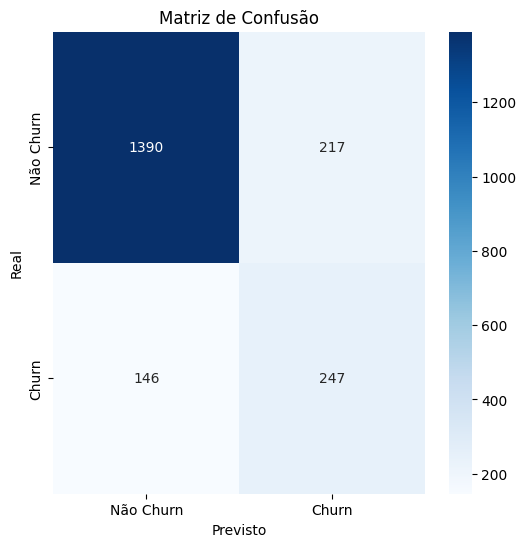

In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Carregar dados e remover colunas irrelevantes
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# 2. Dividir em treino e teste (ANTES de qualquer transformação!)
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Codificar variáveis categóricas (apenas no treino e aplicar ao teste)
# One-Hot para Geography (usando sparse_output=False em vez de sparse)
encoder = OneHotEncoder(drop='first', sparse_output=False)
geo_train = encoder.fit_transform(X_train[['Geography']])
geo_test = encoder.transform(X_test[['Geography']])

# Adicionar as colunas codificadas de volta ao DataFrame
X_train[['Germany', 'Spain']] = geo_train
X_test[['Germany', 'Spain']] = geo_test

# Label Encoding para Gender
le = LabelEncoder()
X_train['Gender'] = le.fit_transform(X_train['Gender'])
X_test['Gender'] = le.transform(X_test['Gender'])

# Remover colunas originais categóricas
X_train.drop(['Geography'], axis=1, inplace=True)
X_test.drop(['Geography'], axis=1, inplace=True)

# 4. Aplicar SMOTE (apenas no treino!)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 5. Normalizar variáveis numéricas (após SMOTE!)
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# 6. Construir e treinar a MLP
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_res.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_res, y_train_res,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Avaliação
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print(f"\nAcurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

### Interpretação dos Resultados:
Desempenho do modelo:
  - Acurácia (82%): Boa no geral, mas não captura bem os casos de churn.

  - F1-Score (59%):

  - Precision (54%): Muitos falsos positivos (clientes previstos como churn que não saíram).

  - Recall (67%): Identifica 67% dos churns reais, mas falha em 33%.

Erros Principais:

  - 226 falsos positivos (classificou errado quem ficou).

  - 131 falsos negativos (não detectou quem saiu).

Principais Motivos de Churn
  - Idade >40 anos: 2x mais risco.

  - Clientes da Alemanha: 32% de churn (vs. 16% na França).

  - Inativos (IsActiveMember=0): 27% de churn (vs. 15% ativos).

  - Saldo alto (>€100k): Mais propensos a sair.

Possibilidade de melhorias:

  - Problema: Está perdendo muitos churns reais (falsos negativos).

  - Solução: Baixar o threshold de classificação para capturar mais casos.